# Linear Penalized Regs

## Penalized Linear Regressions: A Simulation Experiment

## Data Generating Process: Approximately Sparse

In [1]:
#Imoprt relevant packages
import random
random.seed(1)
import numpy as np
import math
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
warnings.filterwarnings('ignore')

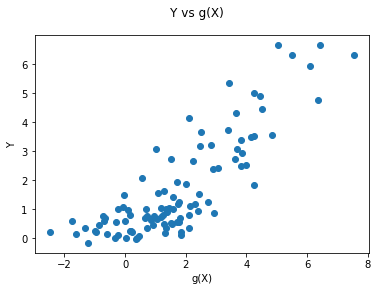

theoretical R2:, 0.7852978477243322


0.7852978477243322

In [2]:
n = 100
p = 400

Z = np.random.uniform( low = 0 , high = 1 , size = n) - 1/2 

W = ( np.random.uniform( low = 0 , high = 1 , size = n * p ) - 1/2 ).\
        reshape( n , p )

beta = ((1/ np.arange(1, p + 1 )) ** 2)

gX = np.exp( 4 * Z ) + (W @ beta)
gX

X = np.concatenate( ( Z.reshape(Z.size, 1), Z.reshape(Z.size, 1) \
                     ** 2, Z.reshape(Z.size, 1) ** 3, W ) , axis = 1 )

mean = 0
sd = 1
Y = gX + np.random.normal( mean , sd, n )

# We use package Glmnet to carry out predictions using cross-validated lasso, ridge, and elastic net
fig = plt.figure()
fig.suptitle('Y vs g(X)')
ax = fig.add_subplot(111)
plt.scatter( Y, gX)
plt.xlabel('g(X)')
plt.ylabel('Y')
plt.show()

print( f"theoretical R2:, {np.var(gX) / np.var( Y )}" ) 

np.var(gX) / np.var( Y ) #theoretical R-square in the simulation example

We use package Glmnet to carry out predictions using cross-validated lasso, ridge, and elastic net

We should know that **cv.glmnet** function in r **standarize** ***X*** data by default. So, we have to standarize our data before the execution of sklearn package. The **normalize** parameter will help for this. However, the function cv.glamnet  is also standarizing the **Y** [variable](https://web.stanford.edu/~hastie/glmnet/glmnet_alpha.html) and then unstadarize the coefficients from the regression. To do this with sklearn, we will standarize the **Y** variable before fitting with **StandardScaler** function. Finally, the r-function uses 10 folds by default so we will adjust our model to use **cv=10** ten folds.\
\
The parameter **l1_ratio** corresponds to **alpha** in the glmnet R package while **alpha** corresponds to the **lambda** parameter in **glmnet**. Specifically, **l1_ratio = 1** is the lasso penalty. Currently, **l1_ratio <= 0.01** is not reliable, unless you supply your own sequence of **alpha**.

In [3]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, ElasticNetCV

In [4]:
# Reshaping Y variable
Y_vec = Y.reshape( Y.size, 1)

# Scalar distribution
scaler = StandardScaler()
scaler.fit( Y_vec )
std_Y = scaler.transform( Y_vec )

# Regressions
fit_lasso_cv = LassoCV(cv = 10 , random_state = 0 , normalize = True ).fit( X, std_Y )
fit_ridge = ElasticNetCV( cv = 10 , normalize = True , random_state = 0 , l1_ratio = 0.0001 ).fit( X, std_Y )
fit_elnet = ElasticNetCV( cv = 10 , normalize = True , random_state = 0 , l1_ratio = 0.5, max_iter = 100000 ).fit( X, std_Y )

# Predictions
yhat_lasso_cv = scaler.inverse_transform( fit_lasso_cv.predict( X ).reshape(-1,1) )
yhat_ridge = scaler.inverse_transform( fit_ridge.predict( X ).reshape(-1,1) )
yhat_elnet = scaler.inverse_transform( fit_elnet.predict( X ).reshape(-1,1) )

In [5]:
MSE_lasso_cv = sm.OLS( ((gX.reshape(-1,1) - yhat_lasso_cv)**2 ) , np.ones( yhat_lasso_cv.shape )  ).fit().summary2().tables[1].round(3)
MSE_ridge = sm.OLS( ((gX.reshape(-1,1) - yhat_ridge)**2 ) , np.ones( yhat_ridge.size )  ).fit().summary2().tables[1].round(3)
MSE_elnet = sm.OLS( ((gX.reshape(-1,1) - yhat_elnet)**2 ) , np.ones( yhat_elnet.size )  ).fit().summary2().tables[1].round(3)
# our coefficient of MSE_elnet are far from r output

Here we compute the lasso and ols post lasso using plug-in choices for penalty levels, using package hdm

Rlasso functionality: it is searching the right set of regressors. This function was made for the case of ***p*** regressors and ***n*** observations where ***p >>>> n***. It assumes that the error is i.i.d. The errors may be non-Gaussian or heteroscedastic.\
The post lasso function makes OLS with the selected ***T*** regressors.
To select those parameters, they use $\lambda$ as variable to penalize\
**Funny thing: the function rlasso was named like that because it is the "rigorous" Lasso.**\
We find a Python code that tries to replicate the main function of hdm r-package. I was made by [Max Huppertz](https://maxhuppertz.github.io/code/). His library is this [repository](https://github.com/maxhuppertz/hdmpy). Download its repository and copy this folder to your site-packages folder. In my case it is located here ***C:\Python\Python38\Lib\site-packages*** .

We need to install this package ***pip install multiprocess***.

In [6]:
import hdmpy

In [7]:
fit_rlasso = hdmpy.rlasso(X, Y, post = False)
fit_rlasso_post = hdmpy.rlasso(X, Y, post = True)

yhat_rlasso = Y - fit_rlasso.est['residuals'].reshape( Y.size,  )
yhat_rlasso_post = Y - fit_rlasso_post.est['residuals'].reshape( Y.size ,  )

MSE_lasso = sm.OLS( ((gX - yhat_rlasso)**2 ) , np.ones( yhat_rlasso.size )  ).fit().summary2().tables[1].round(3)
MSE_lasso_post = sm.OLS( ((gX - yhat_rlasso_post)**2 ) , np.ones( yhat_rlasso_post.size )  ).fit().summary2().tables[1].round(3)


In [8]:
def lava_predict( x, y, iteration = 5 ):
    
    g1_rlasso = hdmpy.rlasso( x, y.reshape(-1,1) , post = False )
    g1 = y.reshape(-1,1) - g1_rlasso.est['residuals']

    new_dep_var = y.reshape(-1,1)-g1
    new_dep_var_vec = new_dep_var.reshape( new_dep_var.size, 1 )

    # Scalar distribution
    scaler = StandardScaler()
    scaler.fit( new_dep_var_vec )
    std_new_dep_var_vec = scaler.transform( new_dep_var_vec )

    fit_ridge_m1 = ElasticNetCV( cv = 10 , normalize = True , random_state = 0 , l1_ratio = 0.0001, alphas = np.array([20]) ).fit( x, std_new_dep_var_vec )
    m1 = scaler.inverse_transform( fit_ridge_m1.predict( x ).reshape(-1,1) )
    
    i = 1
    while i <= iteration:
        
        g1_rlasso = hdmpy.rlasso( x, y , post = False )
        g1 = y - g1_rlasso.est['residuals'].reshape( g1_rlasso.est['residuals'].size, )

        new_dep_var = y-g1
        new_dep_var_vec = new_dep_var.reshape( new_dep_var.size, 1 )

        # Scalar distribution
        scaler = StandardScaler()
        scaler.fit( new_dep_var_vec )
        std_new_dep_var_vec = scaler.transform( new_dep_var_vec )

        fit_ridge_m1 = ElasticNetCV( cv = 10 , normalize = True , random_state = 0 , l1_ratio = 0.0001, alphas = np.array([20]) ).fit( x, std_new_dep_var_vec )
        m1 = scaler.inverse_transform( fit_ridge_m1.predict( x ).reshape(-1,1) )
        
        i = i + 1
        
    return ( g1.reshape(-1,1) + m1.reshape(-1,1) )
        

Next we code up lava, which alternates the fitting of lasso and ridge

In [9]:
yhat_lava = lava_predict( X, Y )
MSE_lava = sm.OLS( ((gX.reshape(-1,1) - yhat_lava)**2 ) , np.ones( yhat_lava.size )  ).fit().summary2().tables[1].round(3)

In [10]:
import pandas as pd

In [11]:
table2 = np.zeros( (6, 2) )

table2[0, 0:] = MSE_lasso_cv.iloc[0, 0:2].to_list()
table2[1, 0:] = MSE_ridge.iloc[0, 0:2].to_list()
table2[2, 0:] = MSE_elnet.iloc[0, 0:2].to_list()
table2[3, 0:] = MSE_lasso.iloc[0, 0:2].to_list()
table2[4, 0:] = MSE_lasso_post.iloc[0, 0:2].to_list()
table2[5, 0:] = MSE_lava.iloc[0, 0:2].to_list()



table2_pandas = pd.DataFrame( table2, columns = [ "MSA","S.E. for MSA" ])
table2_pandas.index = [ "Cross-Validated Lasso",\
                       "Cross-Validated Ridge", "Cross-Validated elnet",\
                       "Lasso", "Post-Lasso", "Lava" ]
table2_pandas = table2_pandas.round(3)
table2_html = table2_pandas.to_html()
table2_pandas

,MSA,S.E. for MSA
Cross-Validated Lasso,0.315,0.067
Cross-Validated Ridge,2.546,0.432
Cross-Validated elnet,0.577,0.079
Lasso,0.322,0.068
Post-Lasso,0.191,0.031
Lava,0.321,0.067


In [12]:
import matplotlib.pyplot as plt

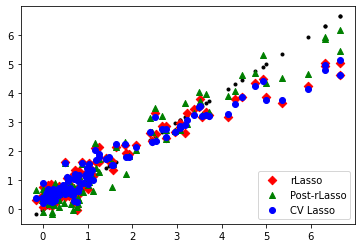

In [13]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter( gX, gX , marker = '.', c = 'black' )
ax1.scatter( gX, yhat_rlasso , marker = 'D' , c = 'red' , label = 'rLasso' )
ax1.scatter( gX, yhat_rlasso_post , marker = '^' , c = 'green' , label = 'Post-rLasso')
ax1.scatter( gX, yhat_lasso_cv , marker = 'o' , c = 'blue' , label = 'CV Lasso')
plt.legend(loc='lower right')
plt.show()

## Data Generating Process: Approximately Sparse + Small Dense Part

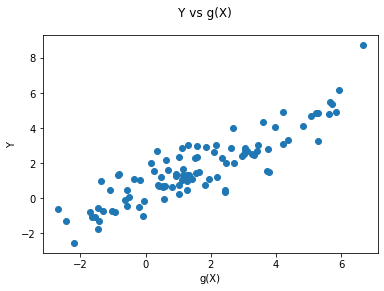

theoretical R2:, 0.782010420087922


0.782010420087922

In [14]:
n = 100
p = 400

Z = np.random.uniform( low = 0 , high = 1 , size = n) - 1/2 

W = ( np.random.uniform( low = 0 , high = 1 , size = n * p ) - 1/2 ).\
        reshape( n , p )
mean = 0
sd = 1

beta = ((np.random.normal( mean , sd, p )) * 0.2)
gX = np.exp( 4 * Z ) + (W @ beta)
X = np.concatenate( ( Z.reshape(Z.size, 1), Z.reshape(Z.size, 1) \
                     ** 2, Z.reshape(Z.size, 1) ** 3, W ) , axis = 1 )
random.seed(2)
Y = gX + np.random.normal( mean , sd, n )

# We use package Glmnet to carry out predictions using cross-validated lasso, ridge, and elastic net
fig = plt.figure()
fig.suptitle('Y vs g(X)')
ax = fig.add_subplot(111)
plt.scatter( Y, gX)
plt.xlabel('g(X)')
plt.ylabel('Y')
plt.show()

print( f"theoretical R2:, {np.var(gX) / np.var( Y )}" ) 

np.var(gX) / np.var( Y ) #theoretical R-square in the simulation example

In [15]:
# Reshaping Y variable
Y_vec = Y.reshape( Y.size, 1)

# Scalar distribution
scaler = StandardScaler()
scaler.fit( Y_vec )
std_Y = scaler.transform( Y_vec )

# Regressions
fit_lasso_cv = LassoCV(cv = 10 , random_state = 0 , normalize = True ).fit( X, std_Y )
fit_ridge = ElasticNetCV( cv = 10 , normalize = True , random_state = 0 , l1_ratio = 0.0001 ).fit( X, std_Y )
fit_elnet = ElasticNetCV( cv = 10 , normalize = True , random_state = 0 , l1_ratio = 0.5, max_iter = 100000 ).fit( X, std_Y )

# Predictions
yhat_lasso_cv = scaler.inverse_transform( fit_lasso_cv.predict( X ).reshape(-1,1) )
yhat_ridge = scaler.inverse_transform( fit_ridge.predict( X ).reshape(-1,1) )
yhat_elnet = scaler.inverse_transform( fit_elnet.predict( X ).reshape(-1,1) )

In [16]:
import statsmodels.api as sm

In [17]:
MSE_lasso_cv = sm.OLS( ((gX.reshape(-1,1) - yhat_lasso_cv)**2 ) , np.ones( yhat_lasso_cv.shape )  ).fit().summary2().tables[1].round(3)
MSE_ridge = sm.OLS( ((gX.reshape(-1,1) - yhat_ridge)**2 ) , np.ones( yhat_ridge.size )  ).fit().summary2().tables[1].round(3)
MSE_elnet = sm.OLS( ((gX.reshape(-1,1) - yhat_elnet)**2 ) , np.ones( yhat_elnet.size )  ).fit().summary2().tables[1].round(3)
# our coefficient of MSE_elnet are far from r output

In [18]:
fit_rlasso = hdmpy.rlasso(X, Y, post = False)
fit_rlasso_post = hdmpy.rlasso(X, Y, post = True)

yhat_rlasso = Y - fit_rlasso.est['residuals'].reshape( Y.size,  )
yhat_rlasso_post = Y - fit_rlasso_post.est['residuals'].reshape( Y.size ,  )

MSE_lasso = sm.OLS( ((gX - yhat_rlasso)**2 ) , np.ones( yhat_rlasso.size )  ).fit().summary2().tables[1].round(3)
MSE_lasso_post = sm.OLS( ((gX - yhat_rlasso_post)**2 ) , np.ones( yhat_rlasso_post.size )  ).fit().summary2().tables[1].round(3)

In [19]:
def lava_predict( x, y, iteration = 5 ):
    
    g1_rlasso = hdmpy.rlasso( x, y.reshape(-1,1) , post = False )
    g1 = y.reshape(-1,1) - g1_rlasso.est['residuals']

    new_dep_var = y.reshape(-1,1)-g1
    new_dep_var_vec = new_dep_var.reshape( new_dep_var.size, 1 )

    # Scalar distribution
    scaler = StandardScaler()
    scaler.fit( new_dep_var_vec )
    std_new_dep_var_vec = scaler.transform( new_dep_var_vec )

    fit_ridge_m1 = ElasticNetCV( cv = 10 , normalize = True , random_state = 0 , l1_ratio = 0.0001, alphas = np.array([20]) ).fit( x, std_new_dep_var_vec )
    m1 = scaler.inverse_transform( fit_ridge_m1.predict( x ).reshape(-1,1) )
    
    i = 1
    while i <= iteration:
        
        g1_rlasso = hdmpy.rlasso( x, y , post = False )
        g1 = y - g1_rlasso.est['residuals'].reshape( g1_rlasso.est['residuals'].size, )

        new_dep_var = y-g1
        new_dep_var_vec = new_dep_var.reshape( new_dep_var.size, 1 )

        # Scalar distribution
        scaler = StandardScaler()
        scaler.fit( new_dep_var_vec )
        std_new_dep_var_vec = scaler.transform( new_dep_var_vec )

        fit_ridge_m1 = ElasticNetCV( cv = 10 , normalize = True , random_state = 0 , l1_ratio = 0.0001, alphas = np.array([20]) ).fit( x, std_new_dep_var_vec )
        m1 = scaler.inverse_transform( fit_ridge_m1.predict( x ).reshape(-1,1) )
        
        i = i + 1
        
    return ( g1.reshape(-1,1) + m1.reshape(-1,1) )
        

In [20]:
yhat_lava = lava_predict( X, Y )
MSE_lava = sm.OLS( ((gX.reshape(-1,1) - yhat_lava)**2 ) , np.ones( yhat_lava.size )  ).fit().summary2().tables[1].round(3)

In [21]:
table2 = np.zeros( (6, 2) )

table2[0, 0:] = MSE_lasso_cv.iloc[0, 0:2].to_list()
table2[1, 0:] = MSE_ridge.iloc[0, 0:2].to_list()
table2[2, 0:] = MSE_elnet.iloc[0, 0:2].to_list()
table2[3, 0:] = MSE_lasso.iloc[0, 0:2].to_list()
table2[4, 0:] = MSE_lasso_post.iloc[0, 0:2].to_list()
table2[5, 0:] = MSE_lava.iloc[0, 0:2].to_list()



table2_pandas = pd.DataFrame( table2, columns = [ "MSA","S.E. for MSA" ])
table2_pandas.index = [ "Cross-Validated Lasso",\
                       "Cross-Validated Ridge", "Cross-Validated elnet",\
                       "Lasso", "Post-Lasso", "Lava" ]
table2_pandas = table2_pandas.round(3)
table2_html = table2_pandas.to_html()
table2_pandas

,MSA,S.E. for MSA
Cross-Validated Lasso,0.858,0.125
Cross-Validated Ridge,3.202,0.575
Cross-Validated elnet,1.021,0.144
Lasso,0.863,0.173
Post-Lasso,1.286,0.209
Lava,0.861,0.173


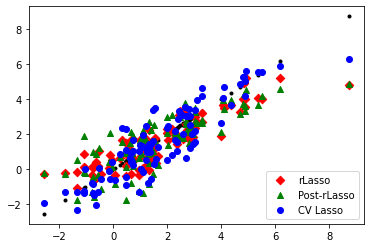

In [22]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter( gX, gX , marker = '.', c = 'black' )
ax1.scatter( gX, yhat_rlasso , marker = 'D' , c = 'red' , label = 'rLasso' )
ax1.scatter( gX, yhat_rlasso_post , marker = '^' , c = 'green' , label = 'Post-rLasso')
ax1.scatter( gX, yhat_lasso_cv , marker = 'o' , c = 'blue' , label = 'CV Lasso')
plt.legend(loc='lower right')
plt.show()